In [1]:
import numpy as np
import open3d as o3d
from tools import load, project, camera
# auto reload packages
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Visualize point cloud from lidar data
## Load Data
First go to the [IGN geoservice](https://geoservices.ign.fr/lidarhd) website.  
Select the desired tiles in the interactive map and download the url list as a txt file.  

In [2]:
datadir = "./data/MNS/"
# can take time, needed only once
#load.download_and_load(datadir, datadir+"liste_dalle_extended.txt", 10000)
#pc = load.load_pcd(datadir, "saved_terrain_customname")

In [3]:
# import pcd file
pc = o3d.io.read_point_cloud(datadir+"saved_terrain_15x15_extended.pcd")

In [4]:
# display test
o3d.visualization.draw_geometries([pc])

## Define view point

In [5]:
lat = 44.5451545715
lon = 4.2165341377
altitude=780
view_point = project.to_lambert93(lat, lon, altitude)

In [6]:
# Add a sphere at view point
sphere = o3d.geometry.TriangleMesh.create_sphere(radius=15)
sphere.translate(view_point)

TriangleMesh with 762 points and 1520 triangles.

In [7]:
width = 1280
height = 720
# read camera parameters
parameters = o3d.io.read_pinhole_camera_parameters("ScreenCamera_viewpoint.json")
# change intrinsic and extrinsinc matrices in this file
# for example, the following function compute the focal length in pixels from the camera parameters
camera.get_focal_length_px(4, 1/2.49)

(914.206475584154, 914.2064755841538)

In [8]:
# example to set the camera to the registered location
camera.visualize([pc, sphere], parameters)

## Set camera actions

Register camera position (to do once per viewpoint):
- place camera vertically to have viewpoint around the center (eventually use U)
- use L to lock the viewpoint direction
- use T to translate until viewpoint is reached
- use P to save the camera parameters

Place camera to viewpoint:
- use V to set view
- use left/right arrows to rotate until desired view is obtained
- use D to save depth parameters

In [9]:
key_to_callback = camera.callbacks(parameters, view_point)
o3d.visualization.draw_geometries_with_key_callbacks([pc, sphere], key_to_callback, width=width, height=height)

field of view: 58.83082333196006


# Extract skyline
Based on [A New Method of Improving the Azimuth in Mountainous Terrain by Skyline Matching](https://link.springer.com/article/10.1007/s41064-020-00093-1) by Nagy Balázs (2019)

In [10]:
spherical = project.array_cartesian_to_spherical(pc.points, view_point)
angles = project.get_deg_angles(spherical)

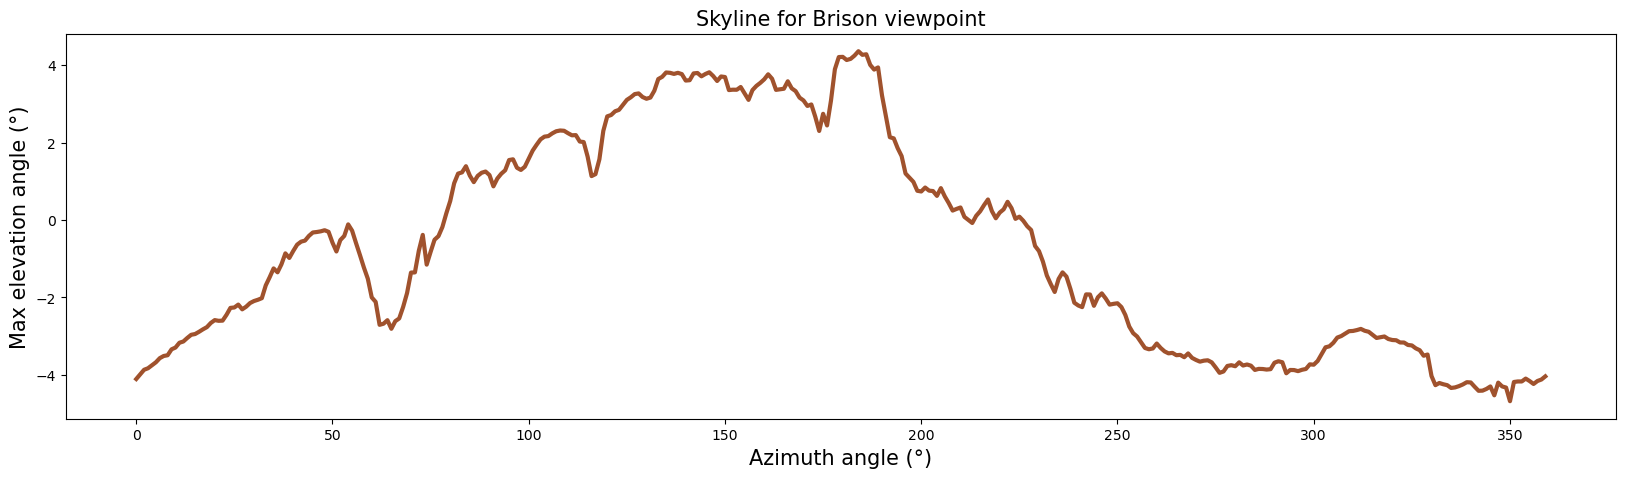

In [99]:
skyline = project.get_skyline(angles)
project.plot_skyline(skyline, 'Skyline for Brison viewpoint')

## Project skyline on terrain
![](./data/plots/skyline_terrain.png)

In [ ]:
max_z = np.max(np.asarray(pc.points)[:,2])
skyline_points = project.skyline_to_cartesian(spherical, angles, skyline, view_point, max_z)

In [ ]:
camera.save_skyline_with_terrain(pc, skyline_points, './data/plots/skyline_terrain.png')

## Compare with image skyline

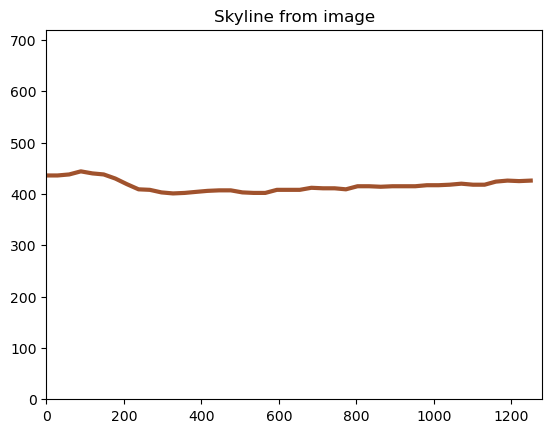

In [242]:
fov = 43 # field of view
image_skyline = load.load_skyline('data/horizon/horizon_contour_b1.npy', fov, width, height, plot=True)

In [107]:
import random

for i in range(43):
    image_skyline[i] = random.randint(0,100)

In [293]:
def normalize(v):
    mini = min(v)
    maxi = max(v)
    n = (v-mini)/(maxi-mini)
    return n/np.std(n)

In [296]:
# cross correlation between reference signal (panoramic skyline) and shifted/noisy signal (skyline from image)
cc = np.correlate(normalize(skyline), normalize(image_skyline), "same")
# Argmax of cross correlation is the best matching azimuth
azimuth = np.argmax(cc)
azimuth

166

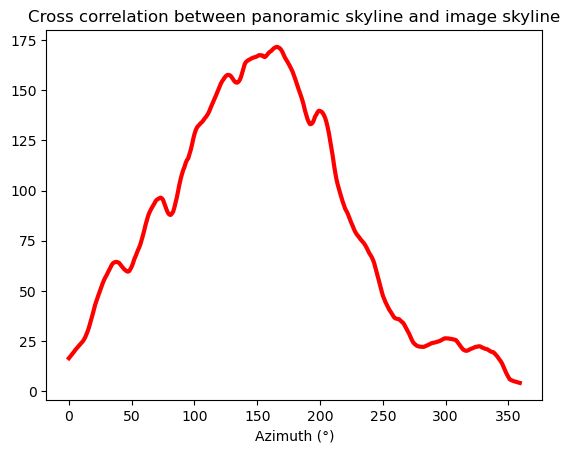

In [297]:
import matplotlib.pyplot as plt
plt.plot(cc, linewidth=3, color='red')
plt.title('Cross correlation between panoramic skyline and image skyline')
plt.xlabel('Azimuth (°)')
plt.show()

## Retrieve view at given azimuth
In this example, the correct azimuth is more around 225°.  
The error is explainable: the image has far mountains that are not visible in the point cloud.  

In [299]:
azimuth=141 #225

In [300]:
parameters.extrinsic = camera.get_extrinsic(azimuth, view_point)

In [304]:
camera.visualize([pc], parameters)

## Retrieve coordinates from depth map

In [302]:
# load depth previously saved, but can later be done automatically from extrinsic parameters corresponding to a specific azimuth
depths = np.load('./data/plots/test_depth.npy')
param = o3d.io.read_pinhole_camera_parameters('./data/plots/test_parameters.json')

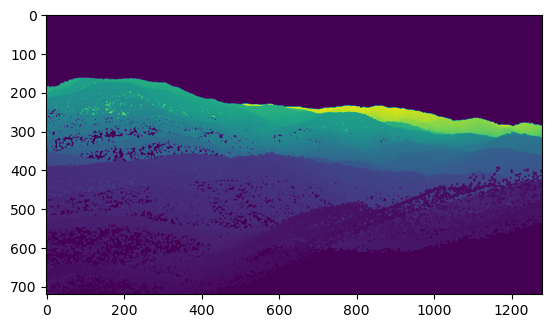

In [303]:
plt.imshow(depths)
plt.show()
# need to fill the gaps between points

In [124]:
u = 60
v = 170
x,y,z = project.unproject(u,v,depths[v,u], param)

In [125]:
project.to_lat_lon(x, y, z)

array([  44.58960918,    4.21476575, 1636.25035766])